<a href="https://colab.research.google.com/github/Mrunali95/Thesis/blob/master/Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('fivethirtyeight')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
## Download data of US Dollar Index

dfUSD = web.DataReader('DX-Y.NYB', data_source='yahoo',start='1990-01-01',end='2020-01-01')

dfUSD.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-01,93.309998,93.080002,93.190002,93.209999,0.0,93.209999
1990-01-02,94.309998,93.080002,93.129997,94.290001,0.0,94.290001
1990-01-03,94.519997,94.080002,94.150002,94.419998,0.0,94.419998
1990-01-04,93.879997,92.389999,93.720001,92.519997,0.0,92.519997
1990-01-05,93.419998,92.550003,93.339996,92.849998,0.0,92.849998


In [ ]:
## download data of NASDAQ index

dfnasdaq = web.DataReader('^IXIC', data_source='yahoo',start='1990-01-01',end='2020-01-01')

dfnasdaq.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,459.299988,452.700012,452.899994,459.299988,110720000,459.299988
1990-01-03,461.600006,460.000000,461.100006,460.899994,152660000,460.899994
1990-01-04,460.799988,456.899994,460.399994,459.399994,147950000,459.399994
1990-01-05,459.399994,457.799988,457.899994,458.200012,137230000,458.200012
1990-01-08,458.700012,456.500000,457.100006,458.700012,115500000,458.700012


In [ ]:
## download data of Dow Jones Industrial Average index

dfdaia = web.DataReader('^DJI', data_source='yahoo',start='1990-01-01',end='2020-01-01')

dfdaia.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,2811.649902,2732.510010,2748.719971,2810.149902,20680000,2810.149902
1990-01-03,2834.040039,2786.260010,2814.199951,2809.729980,23620000,2809.729980
1990-01-04,2821.459961,2766.419922,2804.389893,2796.080078,24370000,2796.080078
1990-01-05,2810.149902,2758.110107,2786.899902,2773.250000,20290000,2773.250000
1990-01-08,2803.969971,2753.409912,2761.729980,2794.370117,16610000,2794.370117


In [ ]:
## download data of S&P 500 index

dfsp = web.DataReader('^GSPC', data_source='yahoo',start='1990-01-01',end='2020-01-01')

dfsp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,359.690002,351.980011,353.399994,359.690002,162070000,359.690002
1990-01-03,360.589996,357.890015,359.690002,358.760010,192330000,358.760010
1990-01-04,358.760010,352.890015,358.760010,355.670013,177000000,355.670013
1990-01-05,355.670013,351.350006,355.670013,352.200012,158530000,352.200012
1990-01-08,354.239990,350.540009,352.200012,353.790009,140110000,353.790009


In [ ]:
## download data of NYSE index

dfnyse = web.DataReader('^NYA', data_source='yahoo',start='1990-01-01',end='2020-01-01')

dfnyse.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,2093.600098,2093.600098,2093.600098,2093.600098,0,2093.600098
1990-01-03,2091.479980,2091.479980,2091.479980,2091.479980,0,2091.479980
1990-01-04,2075.520020,2075.520020,2075.520020,2075.520020,0,2075.520020
1990-01-05,2058.070068,2058.070068,2058.070068,2058.070068,0,2058.070068
1990-01-08,2065.370117,2065.370117,2065.370117,2065.370117,0,2065.370117


In [ ]:
newdfUSD = dfUSD[(dfUSD.index).isin(dfnasdaq.index)]


In [ ]:
absent = dfdaia[~(dfdaia.index).isin(newdfUSD.index)]

In [ ]:
newdfnasdaq = dfnasdaq[~(dfnasdaq.index).isin(absent.index)]
newdfdaia = dfdaia[~(dfdaia.index).isin(absent.index)]
newdfnyse = dfnyse[~(dfnyse.index).isin(absent.index)]
newdfsp = dfsp[~(dfsp.index).isin(absent.index)]

In [ ]:
finaldata = pd.DataFrame(columns=['USD','NASDAQ','DJAI','NYSE','S&P'])

finaldata['USD'] = newdfUSD['Close']
finaldata['NASDAQ'] = newdfnasdaq['Close']
finaldata['DJAI'] = newdfdaia['Close']
finaldata['NYSE'] = newdfnyse['Close']
finaldata['S&P'] = newdfsp['Close']

finaldata.head()

,USD,NASDAQ,DJAI,NYSE,S&P
Date,,,,,
1990-01-02,94.290001,459.299988,2810.149902,2093.600098,359.690002
1990-01-03,94.419998,460.899994,2809.729980,2091.479980,358.760010
1990-01-04,92.519997,459.399994,2796.080078,2075.520020,355.670013
1990-01-05,92.849998,458.200012,2773.250000,2058.070068,352.200012
1990-01-08,92.050003,458.700012,2794.370117,2065.370117,353.790009


In [ ]:
from sklearn.preprocessing import MinMaxScaler

uscaler = MinMaxScaler(feature_range=(0, 1))
unorm = uscaler.fit_transform(np.array(finaldata['USD']).reshape(-1,1))

nqscaler = MinMaxScaler(feature_range=(0, 1))
nqnorm = nqscaler.fit_transform(np.array(finaldata['NASDAQ']).reshape(-1,1))

dscaler = MinMaxScaler(feature_range=(0, 1))
dnorm = dscaler.fit_transform(np.array(finaldata['DJAI']).reshape(-1,1))

nyscaler = MinMaxScaler(feature_range=(0, 1))
nynorm = nyscaler.fit_transform(np.array(finaldata['NYSE']).reshape(-1,1))

spscaler = MinMaxScaler(feature_range=(0, 1))
spnorm = spscaler.fit_transform(np.array(finaldata['S&P']).reshape(-1,1))

In [ ]:
normdata = pd.DataFrame(columns=['USD','NASDAQ','DJAI','NYSE','S&P'])

normdata['USD'] = unorm.flatten()
normdata['NASDAQ'] = nqnorm.flatten()
normdata['DJAI'] = dnorm.flatten()
normdata['NYSE'] = nynorm.flatten()
normdata['S&P'] = spnorm.flatten()

normdata.index = finaldata.index

In [ ]:
normdata['Date'] = normdata.index
normdata['Date'] = pd.to_datetime(normdata['Date'])

In [ ]:
train = normdata[:int(len(normdata)*0.8)]
test = normdata[int(len(normdata)*0.8):]

In [ ]:
df = train

df = df.rename(columns={'USD':'y','Date':'ds'})

In [ ]:
test = test.rename(columns={'USD':'y','Date':'ds'})

In [ ]:
df

,y,NASDAQ,DJAI,NYSE,S&P,ds
Date,,,,,,
1990-01-02,0.463183,0.015396,0.016935,0.030954,0.021813,1990-01-02
1990-01-03,0.465806,0.015580,0.016919,0.030781,0.021497,1990-01-03
1990-01-04,0.427476,0.015408,0.016399,0.029476,0.020448,1990-01-04
1990-01-05,0.434133,0.015270,0.015531,0.028049,0.019269,1990-01-05
1990-01-08,0.417995,0.015327,0.016334,0.028646,0.019809,1990-01-08
...,...,...,...,...,...,...
2013-12-10,0.174299,0.429469,0.517806,0.686855,0.511846,2013-12-10
2013-12-11,0.172685,0.422952,0.512875,0.676780,0.504918,2013-12-11
2013-12-12,0.178939,0.422330,0.508914,0.673356,0.502635,2013-12-12


In [ ]:
from fbprophet import Prophet

model = Prophet()
model.add_regressor('DJAI')
model.add_regressor('NASDAQ')
model.add_regressor('NYSE')
model.add_regressor('S&P')
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
pred=model.predict(test.drop('y', axis=1))

In [ ]:
pred.index = pred['ds']
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,DJAI,DJAI_lower,DJAI_upper,NASDAQ,NASDAQ_lower,NASDAQ_upper,NYSE,NYSE_lower,NYSE_upper,S&P,S&P_lower,S&P_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-17,2013-12-17,0.201063,0.141676,0.256752,0.201063,0.201063,-0.089290,-0.089290,-0.089290,-0.210940,-0.210940,-0.210940,-0.907097,-0.907097,-0.907097,1.220495,1.220495,1.220495,-0.005872,-0.005872,-0.005872,0.013167,0.013167,0.013167,-0.002950,-0.002950,-0.002950,-0.016089,-0.016089,-0.016089,0.0,0.0,0.0,0.195191
2013-12-18,2013-12-18,0.200977,0.135007,0.253916,0.200977,0.200977,-0.092907,-0.092907,-0.092907,-0.215435,-0.215435,-0.215435,-0.942552,-0.942552,-0.942552,1.266251,1.266251,1.266251,-0.003788,-0.003788,-0.003788,0.015357,0.015357,0.015357,-0.002761,-0.002761,-0.002761,-0.016384,-0.016384,-0.016384,0.0,0.0,0.0,0.197188
2013-12-19,2013-12-19,0.200890,0.140373,0.261026,0.200890,0.200890,-0.093044,-0.093044,-0.093044,-0.214280,-0.214280,-0.214280,-0.941979,-0.941979,-0.941979,1.264631,1.264631,1.264631,-0.004519,-0.004519,-0.004519,0.015328,0.015328,0.015328,-0.003237,-0.003237,-0.003237,-0.016610,-0.016610,-0.016610,0.0,0.0,0.0,0.196371
2013-12-20,2013-12-20,0.200804,0.139477,0.258736,0.200804,0.200804,-0.093564,-0.093564,-0.093564,-0.218797,-0.218797,-0.218797,-0.951543,-0.951543,-0.951543,1.278088,1.278088,1.278088,-0.004705,-0.004705,-0.004705,0.014184,0.014184,0.014184,-0.002127,-0.002127,-0.002127,-0.016762,-0.016762,-0.016762,0.0,0.0,0.0,0.196100
2013-12-23,2013-12-23,0.200546,0.135054,0.254115,0.200546,0.200546,-0.094472,-0.094472,-0.094472,-0.223077,-0.223077,-0.223077,-0.962407,-0.962407,-0.962407,1.293011,1.293011,1.293011,-0.006489,-0.006489,-0.006489,0.013055,0.013055,0.013055,-0.002771,-0.002771,-0.002771,-0.016772,-0.016772,-0.016772,0.0,0.0,0.0,0.194057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,2019-12-23,0.011655,-1.367222,2.897483,-2.113537,2.142626,-0.245932,-0.245932,-0.245932,-0.688008,-0.688008,-0.688008,-1.746856,-1.746856,-1.746856,3.447391,3.447391,3.447391,0.747007,0.747007,0.747007,0.766596,0.766596,0.766596,-0.002771,-0.002771,-0.002771,-0.016817,-0.016817,-0.016817,0.0,0.0,0.0,0.758662
2019-12-26,2019-12-26,0.011396,-1.358118,2.899714,-2.118832,2.145626,-0.246795,-0.246795,-0.246795,-0.695446,-0.695446,-0.695446,-1.755537,-1.755537,-1.755537,3.471929,3.471929,3.471929,0.754630,0.754630,0.754630,0.774151,0.774151,0.774151,-0.003237,-0.003237,-0.003237,-0.016283,-0.016283,-0.016283,0.0,0.0,0.0,0.766027
2019-12-27,2019-12-27,0.011310,-1.362743,2.901042,-2.120597,2.146626,-0.247090,-0.247090,-0.247090,-0.693918,-0.693918,-0.693918,-1.756336,-1.756336,-1.756336,3.472099,3.472099,3.472099,0.756654,0.756654,0.756654,0.774755,0.774755,0.774755,-0.002127,-0.002127,-0.002127,-0.015974,-0.015974,-0.015974,0.0,0.0,0.0,0.767964


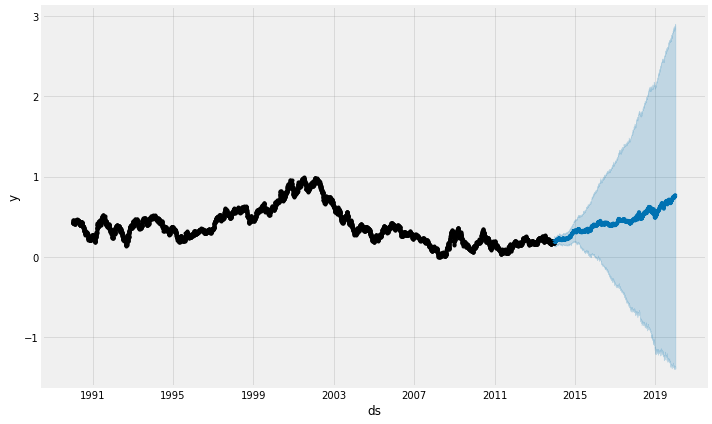

In [ ]:
fig1 = model.plot(pred)

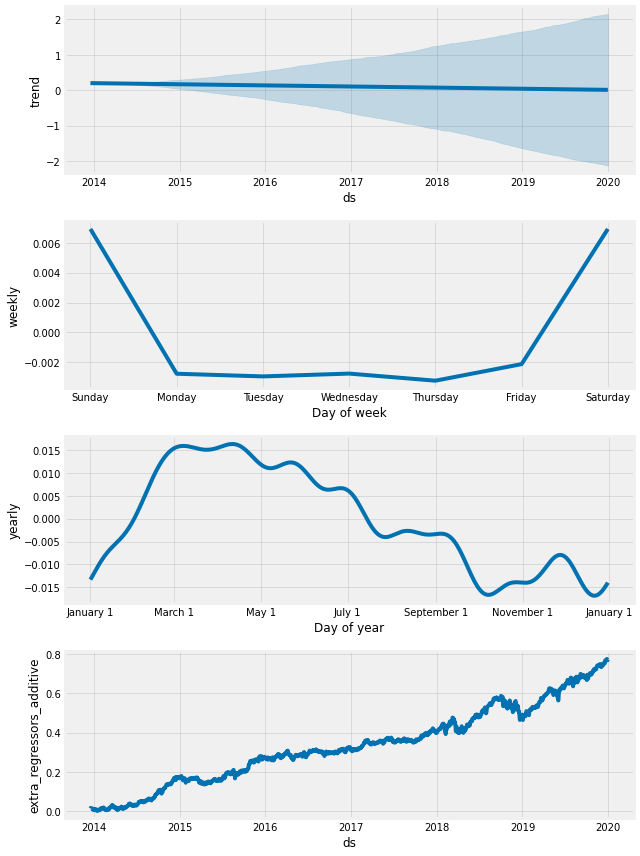

In [ ]:
fig2 = model.plot_components(pred)

In [ ]:
y=np.array(test['y']).reshape(-1,1)
yt = uscaler.inverse_transform(y)
yt = np.array(yt).flatten()

In [ ]:
p = pred['yhat']
y=np.array(p).reshape(-1,1)
pt = uscaler.inverse_transform(y)
pt = np.array(pt).flatten()

In [ ]:
yt = pd.Series(yt, index=p.index)
pt = pd.Series(pt, index=p.index)

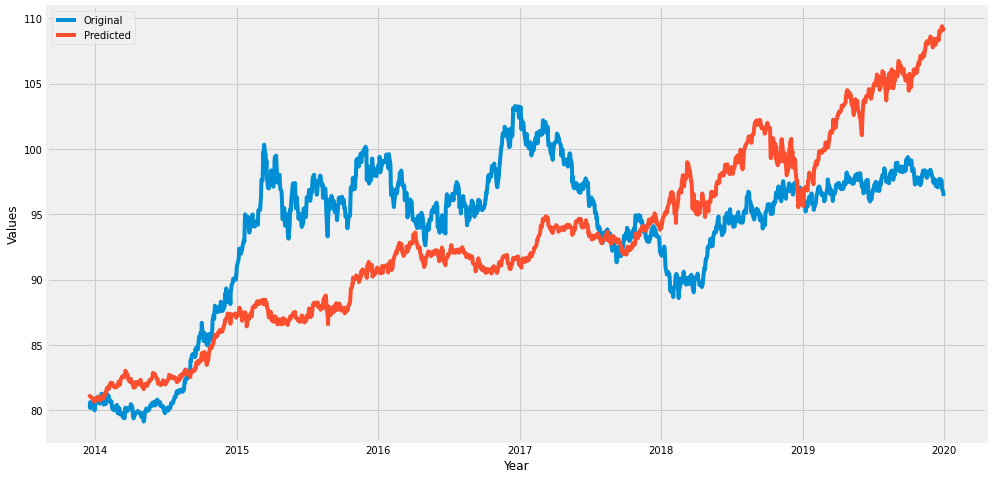

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(yt)
plt.plot(pt)
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend(['Original','Predicted'])

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = math.sqrt(mean_squared_error(yt, pt))
print('Root Mean Squared Error: %.3f'% rmse)
mae = mean_absolute_error(yt, pt)
print('Mean Absolute Error: %.3f'% mae)
mape = np.mean(np.abs(pt - yt)/np.abs(yt))
print('Mean Absolute Percentage Error: %.3f'% (mape))

Root Mean Squared Error: 5.837
Mean Absolute Error: 4.949
Mean Absolute Percentage Error: 0.052


In [ ]:
from google.colab import drive
drive.mount('drive')
data = pd.DataFrame(columns=['P_yt','P_pt'])
data['P_yt'] = yt
data['P_pt'] = pt
data.to_csv('Finalresult.csv')
!cp Finalresult.csv "drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


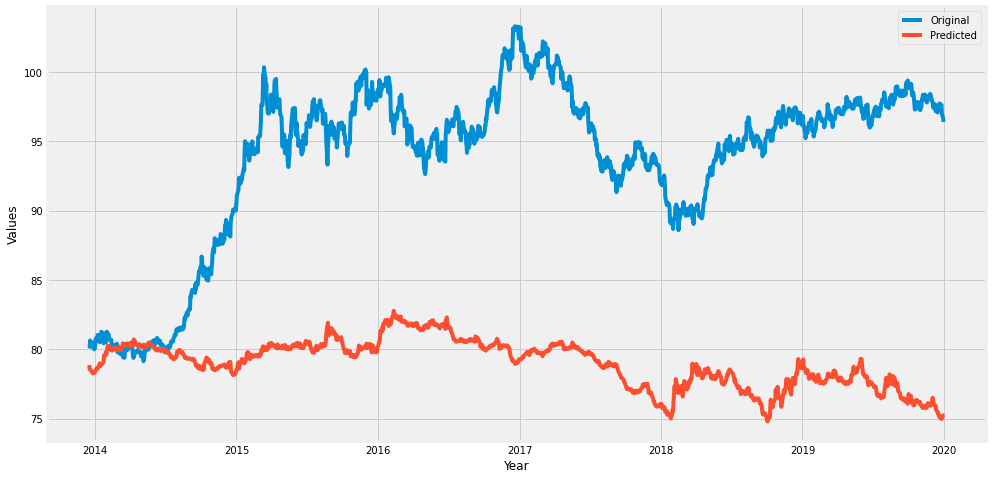

In [ ]:
from fbprophet import Prophet

model = Prophet()
model.add_regressor('DJAI')
#model.add_regressor('NASDAQ')
#model.add_regressor('NYSE')
#model.add_regressor('S&P')
model.fit(df)

pred1=model.predict(test.drop(['y','NASDAQ','NYSE','S&P'], axis=1))
pred1.index = pred1['ds']

p1 = pred1['yhat']
y=np.array(p1).reshape(-1,1)
pt1 = uscaler.inverse_transform(y)
pt1 = np.array(pt1).flatten()
pt1 = pd.Series(pt1, index=p.index)

plt.figure(figsize=(15,8))
plt.plot(yt)
plt.plot(pt1)
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend(['Original','Predicted'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


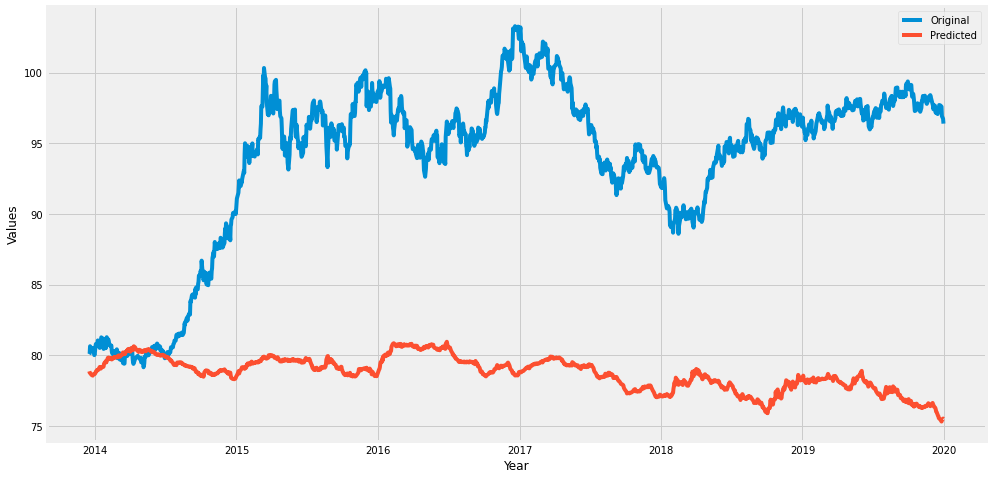

In [ ]:
from fbprophet import Prophet

model = Prophet()
#model.add_regressor('DJAI')
model.add_regressor('NASDAQ')
#model.add_regressor('NYSE')
#model.add_regressor('S&P')
model.fit(df)

pred2=model.predict(test.drop(['y','DJAI','NYSE','S&P'], axis=1))
pred2.index = pred2['ds']

p2= pred2['yhat']
y=np.array(p2).reshape(-1,1)
pt2 = uscaler.inverse_transform(y)
pt2 = np.array(pt2).flatten()
pt2 = pd.Series(pt2, index=p.index)

plt.figure(figsize=(15,8))
plt.plot(yt)
plt.plot(pt2)
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend(['Original','Predicted'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


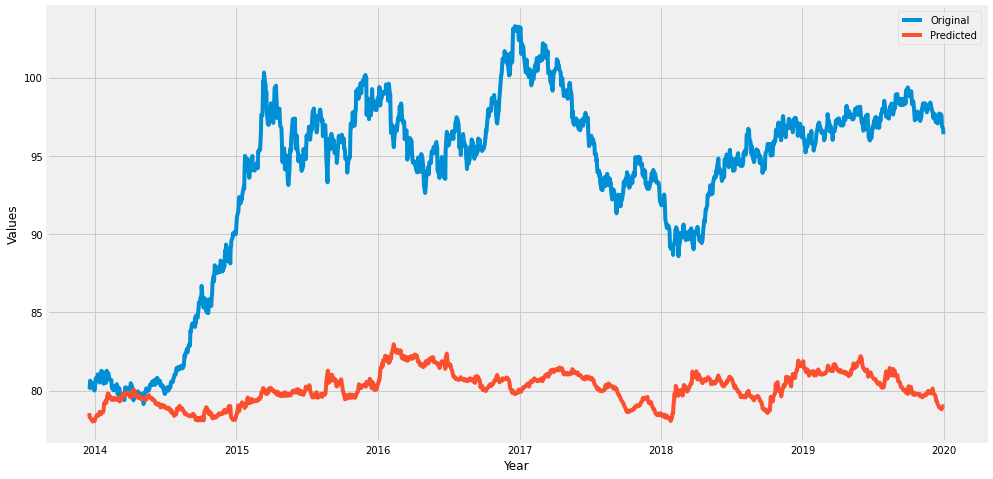

In [ ]:
from fbprophet import Prophet

model = Prophet()
#model.add_regressor('DJAI')
#model.add_regressor('NASDAQ')
model.add_regressor('NYSE')
#model.add_regressor('S&P')
model.fit(df)

pred3=model.predict(test.drop(['y','DJAI','NASDAQ','S&P'], axis=1))
pred3.index = pred3['ds']

p3= pred3['yhat']
y=np.array(p3).reshape(-1,1)
pt3 = uscaler.inverse_transform(y)
pt3 = np.array(pt3).flatten()
pt3 = pd.Series(pt3, index=p.index)

plt.figure(figsize=(15,8))
plt.plot(yt)
plt.plot(pt3)
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend(['Original','Predicted'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


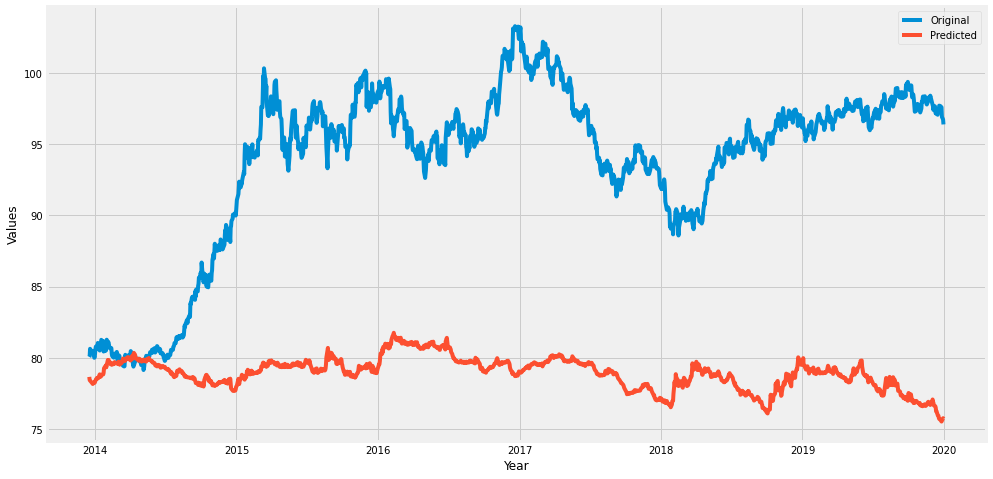

In [ ]:
from fbprophet import Prophet

model = Prophet()
#model.add_regressor('DJAI')
#model.add_regressor('NASDAQ')
#model.add_regressor('NYSE')
model.add_regressor('S&P')
model.fit(df)

pred4=model.predict(test.drop(['y','DJAI','NYSE','NASDAQ'], axis=1))
pred4.index = pred4['ds']

p4= pred4['yhat']
y=np.array(p4).reshape(-1,1)
pt4 = uscaler.inverse_transform(y)
pt4 = np.array(pt4).flatten()
pt4 = pd.Series(pt4, index=p.index)

plt.figure(figsize=(15,8))
plt.plot(yt)
plt.plot(pt4)
plt.xlabel('Year')
plt.ylabel('Values')
plt.legend(['Original','Predicted'])

Text(0, 0.5, 'Values')

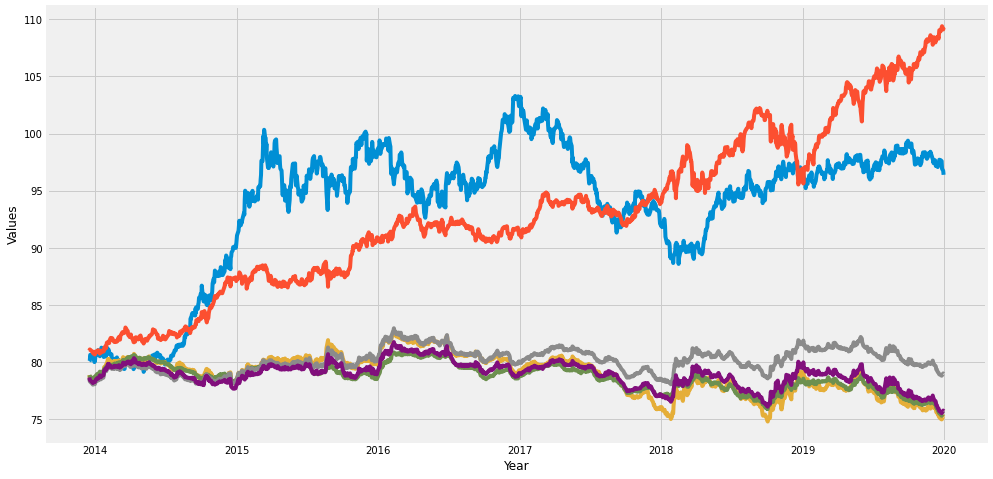

In [ ]:

plt.figure(figsize=(15,8))
plt.plot(yt)
plt.plot(pt)
plt.plot(pt1)
plt.plot(pt2)
plt.plot(pt3)
plt.plot(pt4)
plt.xlabel('Year')
plt.ylabel('Values')